In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import BoundaryNorm, ListedColormap
import matplotlib.colors as mcolors

from paolucci_functions import *

In [2]:
import os
import pandas as pd
import re
import numpy as np

def find_last_energy_value(filename):
    pattern = r"SCF Done:  E\(UPBE-PBE\) =  (-?\d+\.\d+)     A\.U\. after    \d+ cycles"
    last_energy = None
    
    with open(filename, 'r') as file:
        for line in file:
            match = re.search(pattern, line)
            if match:
                last_energy = float(match.group(1))
    
    return last_energy

def parse_frequencies(file_path):
    pattern = r'Frequencies\s+--\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)'  # regex to find desired lines
    frequencies = []

    with open(file_path, 'r') as file:
        for line in file:
            match = re.search(pattern, line)
            if match:
                freq_values = match.groups()
                frequencies.extend(freq_values)
    
    # Convert strings to floats and cutoff frequencies below 100 cm^-1
    no_low_freq = [float(x) for x in frequencies if float(x) >= 100]
    
    return no_low_freq

def calculate_zpe(frequencies):
    h = 6.62607015e-34  # Planck's constant in J*s
    cm_to_hz = 2.99793e10  # convert cm^-1 to Hz
    Na = 6.022e23  # Avogadro's number 
    
    frequencies_array = np.array(frequencies, dtype=float)
    zpe = 0.5 * (h/1000) * np.sum(frequencies_array) * cm_to_hz * Na  # zero point energy in units of kJ/mol
    
    return zpe

def parse_ligand_file(file_name, file_dir):
    # Remove the file extension
    base_name = os.path.splitext(file_name)[0]
    
    # Initialize ligand counts
    n_nh3 = 0
    n_h2o = 0
    n_c2h4 = 0
    
    # Define regular expressions for ligands
    nh3_pattern = re.compile(r'(\d+)_nh3')
    h2o_pattern = re.compile(r'(\d+)_h2o')
    c2h4_pattern = re.compile(r'(\d+)_c2h4')
    
    # Find all matches
    nh3_match = nh3_pattern.search(base_name)
    h2o_match = h2o_pattern.search(base_name)
    c2h4_match = c2h4_pattern.search(base_name)
    
    if nh3_match:
        n_nh3 = int(nh3_match.group(1))
    if h2o_match:
        n_h2o = int(h2o_match.group(1))
    if c2h4_match:
        n_c2h4 = int(c2h4_match.group(1))
    
    # The remaining part after the ligand patterns is the description
    description_parts = nh3_pattern.sub('', base_name)
    description_parts = h2o_pattern.sub('', description_parts)
    description_parts = c2h4_pattern.sub('', description_parts)
    description = description_parts.strip('_')
    
    # Read the log file to find the total energy and frequencies
    total_energy = find_last_energy_value(os.path.join(file_dir, file_name))
    frequencies = parse_frequencies(os.path.join(file_dir, file_name))
    zpe = calculate_zpe(frequencies)
    
    return n_nh3, n_h2o, n_c2h4, description, total_energy, zpe, os.path.join(file_dir, file_name)

def extract_data_from_directory(base_dir):
    data = []
    
    for metal_dir in os.listdir(base_dir):
        if os.path.isdir(os.path.join(base_dir, metal_dir)):
            # Extract metal and charge information
            metal = ''.join([i for i in metal_dir if not i.isdigit()])
            charge = ''.join([i for i in metal_dir if i.isdigit()])
            
            for geometry_dir in os.listdir(os.path.join(base_dir, metal_dir)):
                if os.path.isdir(os.path.join(base_dir, metal_dir, geometry_dir)):
                    geometry = geometry_dir.replace('_', ' ').capitalize()
                    
                    for ligand_file in os.listdir(os.path.join(base_dir, metal_dir, geometry_dir)):
                        if ligand_file.endswith('.log'):  # replace with your file extension
                            n_nh3, n_h2o, n_c2h4, description, total_energy, zpe, file_path = parse_ligand_file(ligand_file, os.path.join(base_dir, metal_dir, geometry_dir))
                            
                            data.append({
                                'Metal': metal.capitalize(),
                                'Charge': charge,
                                'Geometry': geometry,
                                'NH3': n_nh3,
                                'H2O': n_h2o,
                                'C2H4': n_c2h4,
                                'Description': description,
                                'Total Energy (Hartree)': total_energy,
                                'ZPE (kJ/mol)': zpe,
                                'File Path': file_path
                            })
    
    return pd.DataFrame(data)

# Set the base directory path
base_directory = '/Users/mohan/Desktop/Research/paolucci/data/freq'

# Extract the data into a dataframe
df = extract_data_from_directory(base_directory)

# Display the dataframe
df


,Metal,Charge,Geometry,NH3,H2O,C2H4,Description,Total Energy (Hartree),ZPE (kJ/mol),File Path
0,Cu,2,Square planar,1,3,0,,-1925.257977,293.629551,/Users/mohan/Desktop/Research/paolucci/data/fr...
1,Cu,2,Square planar,0,4,0,,-1945.082482,258.343882,/Users/mohan/Desktop/Research/paolucci/data/fr...
2,Cu,2,Square planar,2,2,0,90apart,-1905.432240,327.923744,/Users/mohan/Desktop/Research/paolucci/data/fr...
3,Cu,2,Square planar,2,2,0,180apart,-1905.430468,327.990354,/Users/mohan/Desktop/Research/paolucci/data/fr...
4,Cu,2,Square planar,4,0,0,,-1865.770866,401.772002,/Users/mohan/Desktop/Research/paolucci/data/fr...
5,Cu,2,Square planar,3,1,0,,-1885.602719,364.494520,/Users/mohan/Desktop/Research/paolucci/data/fr...
6,Cu,2,Tetrahedral,0,0,4,,-1953.614546,545.542770,/Users/mohan/Desktop/Research/paolucci/data/fr...
7,Cu,2,Tetrahedral,1,0,2,1n2,-1853.126669,369.653251,/Users/mohan/Desktop/Research/paolucci/data/fr...
8,Cu,2,Tetrahedral,2,2,0,,-1905.432225,328.240905,/Users/mohan/Desktop/Research/paolucci/data/fr...
9,Cu,2,Tetrahedral,1,3,0,,-1925.258761,293.323507,/Users/mohan/Desktop/Research/paolucci/data/fr...


In [3]:
import requests
from bs4 import BeautifulSoup

kb = 1.381e-23

h_p = 6.626e-34

Na = 6.022e23

R = 8.314

nh3_url = "https://janaf.nist.gov/tables/H-083.html"

h2o_url = "https://janaf.nist.gov/tables/H-064.html"

c2h4_url = "https://janaf.nist.gov/tables/C-128.html"

nh3_results = nist_collector(nh3_url)

h2o_results = nist_collector(h2o_url)

c2h4_results = nist_collector(c2h4_url)

zero_k_nh3_entropy = nh3_results[0][1]
zero_k_nh3_enthalpy = nh3_results[0][2]

zero_k_h2o_entropy = h2o_results[0][1]
zero_k_h2o_enthalpy = h2o_results[0][2]

zero_k_c2h4_entropy = c2h4_results[0][1]
zero_k_c2h4_enthalpy = c2h4_results[0][2]

In [4]:
from scipy.interpolate import interp1d

interp_temp = 500 # kelvin

def cubic_interpolator(x, y, temp):
    interp = interp1d(x, y, kind='cubic')
    return interp(temp)

entropy_nh3 = cubic_interpolator(nh3_results[1:-1, 0], nh3_results[1:-1, 1], interp_temp) # [1:-1, 0] Ignore first and last element of first column (0, 298.15 K)

enthalpy_nh3 = cubic_interpolator(nh3_results[1:-1, 0], nh3_results[1:-1, 2], interp_temp)

entropy_h2o = cubic_interpolator(h2o_results[1:-1, 0], h2o_results[1:-1, 1], interp_temp) # [1:-1, 0] Ignore first and last element of first column (0, 298.15 K)

enthalpy_h2o = cubic_interpolator(h2o_results[1:-1, 0], h2o_results[1:-1, 2], interp_temp)

entropy_c2h4 = cubic_interpolator(c2h4_results[1:-1, 0], c2h4_results[1:-1, 1], interp_temp) # [1:-1, 0] Ignore first and last element of first column (0, 298.15 K)

enthalpy_c2h4 = cubic_interpolator(c2h4_results[1:-1, 0], c2h4_results[1:-1, 2], interp_temp)

In [5]:
def filter_dataframe(data: pd.DataFrame, metal:str, charge: int, geom: str) -> pd.DataFrame:
    """
    Returns dataframe with grouping specified by arguments
    """
    if geom:
        return data[(data['Metal'] == metal) & (data['Charge'] == str(charge)) & (data['Geometry'] == geom)]
    else:
        return data[(data['Metal'] == metal) & (data['Charge'] == str(charge))]
    
# new = filter_dataframe(data = df, metal = 'Cu', charge = 2, geom = 'Square planar')

new = filter_dataframe(data = df, metal = 'Co', charge = 2, geom ="Square planar") # CHANGE GEOMETRY HERE

new.insert(10, "Entropy (kJ/mol*K)", None) # insert new, empty column at the end of the dataframe

new

,Metal,Charge,Geometry,NH3,H2O,C2H4,Description,Total Energy (Hartree),ZPE (kJ/mol),File Path,Entropy (kJ/mol*K)
27,Co,2,Square planar,2,0,1,n180,-1573.317922,324.614402,/Users/mohan/Desktop/Research/paolucci/data/fr...,None
28,Co,2,Square planar,0,0,3,n180,-1617.351867,411.305970,/Users/mohan/Desktop/Research/paolucci/data/fr...,None
29,Co,2,Square planar,3,0,1,,-1630.025578,444.461425,/Users/mohan/Desktop/Research/paolucci/data/fr...,None
30,Co,2,Square planar,0,0,2,2n180,-1538.608262,246.952256,/Users/mohan/Desktop/Research/paolucci/data/fr...,None
31,Co,2,Square planar,4,0,0,,-1608.059840,408.674503,/Users/mohan/Desktop/Research/paolucci/data/fr...,None
32,Co,2,Square planar,2,0,2,90apart,-1651.981993,482.613405,/Users/mohan/Desktop/Research/paolucci/data/fr...,None
33,Co,2,Square planar,2,0,1,n90,-1573.408878,333.261250,/Users/mohan/Desktop/Research/paolucci/data/fr...,None
34,Co,2,Square planar,2,2,0,90_apart,-1647.718885,334.581975,/Users/mohan/Desktop/Research/paolucci/data/fr...,None
35,Co,2,Square planar,3,1,0,,-1627.889959,370.750818,/Users/mohan/Desktop/Research/paolucci/data/fr...,None


In [6]:
def reference_energy(reduced_data: pd.DataFrame, num_ligands:int) -> np.float64:
    """
    Returns lowest energy associated with complete saturation of ammonia (lowest if comparing b/t geometries)
    """
    intermediate = reduced_data[(reduced_data['NH3'] == num_ligands)]
    return intermediate['Total Energy (Hartree)'].values

def reference_entropy(reduced_data: pd.DataFrame, num_ligands:int) -> np.float64:
    """
    Returns energy associated with complete saturation of ammonia
    """
    intermediate = reduced_data[(reduced_data['NH3'] == num_ligands)]
    return intermediate["Entropy (kJ/mol*K)"].values

def reference_energy_entropy(reduced_data: pd.DataFrame, num_ligands:int) -> np.float64:
    """
    Returns lowest energy associated with complete saturation of ammonia and the entropy of that species
    """
    intermediate = reduced_data[(reduced_data['NH3'] == num_ligands)]
    min_index = intermediate['Total Energy (Hartree)'].idxmin() # lowest energy of full saturation with NH3 if mult. geometries
    return intermediate.loc[min_index, 'Total Energy (Hartree)'], intermediate.loc[min_index, 'Entropy (kJ/mol*K)']

e_nh3 = -56.4919831888 # hartree
e_h2o = -76.3434909651 # hartree
e_c2h4 = -78.4923922995 # hartree

har_to_kjmol = 2625.5

In [7]:
for row in new.itertuples(index=True):
    
    s_trans, s_vib, s_rot = calc_entropy(infile = row[10], temperature = interp_temp)
    
    total_entropy = (s_trans + s_vib + s_rot)

    new.at[row[0], 'Entropy (kJ/mol*K)']  = total_entropy/1000 # total_entropy is in J/mol*K so divide to get kJ

new.reset_index(drop=True, inplace=True) # reset indices for plotting more easily later

new 

,Metal,Charge,Geometry,NH3,H2O,C2H4,Description,Total Energy (Hartree),ZPE (kJ/mol),File Path,Entropy (kJ/mol*K)
0,Co,2,Square planar,2,0,1,n180,-1573.317922,324.614402,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.427117211060437
1,Co,2,Square planar,0,0,3,n180,-1617.351867,411.305970,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.4531714694137388
2,Co,2,Square planar,3,0,1,,-1630.025578,444.461425,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.4634698923428381
3,Co,2,Square planar,0,0,2,2n180,-1538.608262,246.952256,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.44450714091270593
4,Co,2,Square planar,4,0,0,,-1608.059840,408.674503,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.4809516645227569
5,Co,2,Square planar,2,0,2,90apart,-1651.981993,482.613405,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.523844110425584
6,Co,2,Square planar,2,0,1,n90,-1573.408878,333.261250,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.4198038220606594
7,Co,2,Square planar,2,2,0,90_apart,-1647.718885,334.581975,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.4620598486373522
8,Co,2,Square planar,3,1,0,,-1627.889959,370.750818,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.4636800894827225


In [8]:
# make sure data frame updates correctly since I think I'll have to hand-specify geometries 

four_init = 4

metals = ['Cu']
charges = [2]

for metal in metals:
    for charge in charges:
        # reduced_df = filter_dataframe(df, metal = metal, charge = charge, geom = 'Square planar')
        
        # ref_e = (reference_energy(new, num_ligands = 4)) # this works

        # ref_s = (reference_entropy(new, num_ligands = 4)) # this works

        ref_e, ref_s = reference_energy_entropy(new, num_ligands = 4)

        # delta_e = (new['Total Energy (Hartree)'] + (new['H2O'] * e_nh3) - ref_e - (new['H2O'] * e_h2o) ) * har_to_kjmol # old version 

        delta_e = (new['Total Energy (Hartree)'] + ((four_init - new['NH3']) * e_nh3) - ref_e - (new['H2O'] * e_h2o) - (new['C2H4'] * e_c2h4) ) * har_to_kjmol 

        delta_s = (new['Entropy (kJ/mol*K)'].apply(lambda x: x - ref_s)) 

        new.loc[new.index, 'Delta E (kJ/mol)'] = delta_e # append results back to corresponding row

        new.loc[new.index, 'Delta S (kJ/mol*K)'] = delta_s # append results back to corresponding row

new

/var/folders/2h/yqm73phx7ljgrfkrgb88dx000000gn/T/ipykernel_55290/553465863.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new.loc[new.index, 'Delta E (kJ/mol)'] = delta_e # append results back to corresponding row
/var/folders/2h/yqm73phx7ljgrfkrgb88dx000000gn/T/ipykernel_55290/553465863.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new.loc[new.index, 'Delta S (kJ/mol*K)'] = delta_s # append results back to corresponding row


,Metal,Charge,Geometry,NH3,H2O,C2H4,Description,Total Energy (Hartree),ZPE (kJ/mol),File Path,Entropy (kJ/mol*K),Delta E (kJ/mol),Delta S (kJ/mol*K)
0,Co,2,Square planar,2,0,1,n180,-1573.317922,324.614402,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.427117211060437,657.277258,-0.053834
1,Co,2,Square planar,0,0,3,n180,-1617.351867,411.305970,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.4531714694137388,570.301877,-0.027780
2,Co,2,Square planar,3,0,1,,-1630.025578,444.461425,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.4634698923428381,91.029106,-0.017482
3,Co,2,Square planar,0,0,2,2n180,-1538.608262,246.952256,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.44450714091270593,1229.862187,-0.036445
4,Co,2,Square planar,4,0,0,,-1608.059840,408.674503,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.4809516645227569,0.000000,0.000000
5,Co,2,Square planar,2,0,2,90apart,-1651.981993,482.613405,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.523844110425584,206.535381,0.042892
6,Co,2,Square planar,2,0,1,n90,-1573.408878,333.261250,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.4198038220606594,418.472621,-0.061148
7,Co,2,Square planar,2,2,0,90_apart,-1647.718885,334.581975,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.4620598486373522,115.443688,-0.018892
8,Co,2,Square planar,3,1,0,,-1627.889959,370.750818,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.4636800894827225,56.156285,-0.017272


In [9]:
class fourfold():
    def __init__(self, data, temperature:np.ndarray, p_nh3:np.ndarray, p_h2o:np.ndarray, p_c2h4:np.ndarray):
            self.data = data 
            self.temperature = temperature
            self.p_nh3 = p_nh3
            self.p_h2o = p_h2o
            self.p_c2h4 = p_c2h4

    def vary_ph2o(self):
        mu_h2o = np.zeros_like(self.p_h2o, dtype = np.float32) # constant temp along row; constant pres. down column 

        for p, pres in enumerate(self.p_h2o): # vary P_h2o
            mu_h2o[p] = (enthalpy_h2o - zero_k_h2o_enthalpy) - (self.temperature * entropy_h2o) + (0.008314 * self.temperature * np.log(pres))

        mu_nh3 = (enthalpy_nh3 - zero_k_nh3_enthalpy) - (self.temperature * entropy_nh3) + (0.008314 * self.temperature * np.log(self.p_nh3))
        mu_c2h4 = (enthalpy_c2h4 - zero_k_c2h4_enthalpy) - (self.temperature * entropy_c2h4) + (0.008314 * self.temperature * np.log(self.p_c2h4))

        dE_TdS_mu = []

        for delta in zip(self.data['Delta E (kJ/mol)'].values, self.data['Delta S (kJ/mol*K)'].values, self.data['H2O'], self.data['C2H4'], self.data['NH3']):
            # # delta[0] = dE --> delta[1] = dS --> delta[2] = y from yH2O --> delta[3] = z from zC2H4
            
            delta_mu_h2o = (delta[2] * mu_h2o) # 1D vector
            delta_mu_c2h4 = (delta[3] * mu_c2h4) # 1D vector
            dE_TdS_mu.append(delta[0] - (self.temperature * delta[1]) - delta_mu_h2o - delta_mu_c2h4 + ((4 - delta[4]) * mu_nh3))
        
        return dE_TdS_mu, mu_nh3, mu_h2o, mu_c2h4
    
    def plot_vary_ph2o(self, outfile = None):
                
            dE_TdS_mu, mu_nh3, mu_h2o, mu_c2h4 = self.vary_ph2o()

            fig, ax = plt.subplots()

            for row in self.data.itertuples(index=True):
                linestyle = '--' if row[3] == 'Tetrahedral' else '-'
                ax.plot(self.p_h2o, dE_TdS_mu[row[0]], label = ' '+str(row[4])+"NH3 "+str(row[5])+" H2O "+ str(row[6])+" C2H4 "+str(row[7]), linestyle = linestyle) # , color = colors[row[0]]
                
            ax.set_xlabel(r'log $\left(  \frac{P_{H_2O}}{P \degree} \right)$')
            ax.set_ylabel(r" $\Delta G   \; \; \left[ \frac{kJ}{mol} \right] $")
            ax.set_xscale('log')
            ax.minorticks_off()
            plt.legend(ncol=3, bbox_to_anchor=(0.5, -0.3), loc='center', frameon = False)
            plt.suptitle(f"Free Energy of {self.data['Metal'][0]} {self.data['Charge'][0]}: "+r"$P_{NH_3}$ = "+str(self.p_nh3)+r" atm "+r"$P_{C_2 H_4}$ = "+str(self.p_c2h4)+" atm T = "+str(self.temperature)+' K')
            
            if outfile:
                plt.savefig(outfile, dpi = 400, bbox_inches='tight')
            
            plt.show();
    
    def vary_pc2h4(self):
        mu_c2h4 = np.zeros_like(self.p_c2h4, dtype = np.float32) # constant temp along row; constant pres. down column 

        for p, pres in enumerate(self.p_c2h4): # vary P_h2o
            mu_c2h4[p] = (enthalpy_c2h4 - zero_k_c2h4_enthalpy) - (self.temperature * entropy_c2h4) + (0.008314 * self.temperature * np.log(pres))

        mu_nh3 = (enthalpy_nh3 - zero_k_nh3_enthalpy) - (self.temperature * entropy_nh3) + (0.008314 * self.temperature * np.log(self.p_nh3))
        mu_h2o = (enthalpy_h2o - zero_k_h2o_enthalpy) - (self.temperature * entropy_h2o) + (0.008314 * self.temperature * np.log(self.p_h2o))

        dE_TdS_mu = []

        for delta in zip(self.data['Delta E (kJ/mol)'].values, self.data['Delta S (kJ/mol*K)'].values, self.data['H2O'], self.data['C2H4'], self.data['NH3']):
            # # delta[0] = dE --> delta[1] = dS --> delta[2] = y from yH2O --> delta[3] = z from zC2H4
            
            delta_mu_h2o = (delta[2] * mu_h2o) # 1D vector
            delta_mu_c2h4 = (delta[3] * mu_c2h4) # 1D vector
            dE_TdS_mu.append(delta[0] - (self.temperature * delta[1]) - delta_mu_h2o - delta_mu_c2h4 + ((4 - delta[4]) * mu_nh3))
        
        return dE_TdS_mu, mu_nh3, mu_h2o, mu_c2h4
    
    def plot_vary_pc2h4(self, outfile = None):
                
            dE_TdS_mu, mu_nh3, mu_h2o, mu_c2h4 = self.vary_pc2h4()

            fig, ax = plt.subplots()

            for row in self.data.itertuples(index=True):
                linestyle = '--' if row[3] == 'Tetrahedral' else '-'
                ax.plot(self.p_c2h4, dE_TdS_mu[row[0]], label = ' '+str(row[4])+"NH3 "+str(row[5])+" H2O "+ str(row[6])+" C2H4 "+str(row[7]), linestyle = linestyle) # , color = colors[row[0]]
                
            ax.set_xlabel(r'log $\left(  \frac{P_{C_2 H_4}}{P \degree} \right)$')
            ax.set_ylabel(r" $\Delta G   \; \; \left[ \frac{kJ}{mol} \right] $")
            ax.set_xscale('log')
            ax.minorticks_off()
            plt.legend(ncol=3, bbox_to_anchor=(0.5, -0.3), loc='center', frameon = False)
            plt.suptitle(f"Free Energy of {self.data['Metal'][0]} {self.data['Charge'][0]}: "+r"$P_{NH_3}$ = "+str(self.p_nh3)+r" atm "+r"$P_{H_2 O}$ = "+str(self.p_h2o)+" atm T = "+str(self.temperature)+' K')
            
            if outfile:
                plt.savefig(outfile, dpi = 400, bbox_inches='tight')
            
            plt.show();

    def vary_ph2o_pc2h4(self):
        mu_c2h4 = np.zeros_like(self.p_c2h4, dtype = np.float32) # constant temp along row; constant pres. down column 
        mu_h2o = np.zeros_like(self.p_h2o, dtype = np.float32) # constant temp along row; constant pres. down column 

        for p1, pres_h in enumerate(self.p_h2o): # vary P_h2o
            mu_h2o[p1] = (enthalpy_h2o - zero_k_h2o_enthalpy) - (self.temperature * entropy_h2o) + (0.008314 * self.temperature * np.log(pres_h))

        for p2, pres_c in enumerate(self.p_c2h4): # vary P_c2h4
                mu_c2h4[p2] = (enthalpy_c2h4 - zero_k_c2h4_enthalpy) - (self.temperature * entropy_c2h4) + (0.008314 * self.temperature * np.log(pres_c))
        
        mu_nh3 = (enthalpy_nh3 - zero_k_nh3_enthalpy) - (self.temperature * entropy_nh3) + (0.008314 * self.temperature * np.log(self.p_nh3))

        dE_TdS_mu = []

        for delta in zip(self.data['Delta E (kJ/mol)'].values, self.data['Delta S (kJ/mol*K)'].values, self.data['H2O'], self.data['C2H4'], self.data['NH3']):
            # # delta[0] = dE --> delta[1] = dS --> delta[2] = y from yH2O --> delta[3] = z from zC2H4
            
            delta_mu_h2o = (delta[2] * mu_h2o) # 1D vector
            delta_mu_c2h4 = (delta[3] * mu_c2h4) # 1D vector
            matrix = delta_mu_h2o[:, np.newaxis] + delta_mu_c2h4  # 2D matrix where constant P_h2o along a row, constant P_c2h4 down a column 
            dE_TdS_mu.append(delta[0] - (self.temperature * delta[1]) - matrix + ((4 - delta[4]) * mu_nh3))

        return dE_TdS_mu, mu_nh3, mu_h2o, mu_c2h4

    def plot_vary_p_h2o_pc2h4(self, outfile=None):
        dE_TdS_mu, mu_nh3, mu_h2o, mu_c2h4 = self.vary_ph2o_pc2h4()

        P_C, P_H = np.meshgrid(self.p_c2h4, self.p_h2o)

        min_values = np.minimum.reduce(dE_TdS_mu)

        labels = np.argmin(dE_TdS_mu, axis=0)  # Find minimum value at each index i, j of the tensor

        integer_range = np.arange(0, len(self.data)+1)  # delete if needed
        
        # Use a general colormap for the labels
        cmap = plt.get_cmap('Paired', len(integer_range)) # delete after comma if needed

        norm = mcolors.BoundaryNorm(boundaries=np.arange(-0.5, len(integer_range) + 0.5), ncolors=len(integer_range)) # delete if needed

        # Plotting
        fig, axs = plt.subplots(1, 2, figsize=(15, 5))

        # Create contour plot for the minimum values
        contour_min = axs[0].contourf(P_C, P_H, min_values, cmap='viridis')
        cbar_min = fig.colorbar(contour_min, ax=axs[0], orientation='horizontal')
        cbar_min.set_label(r" $\Delta G   \; \; \left[ \frac{kJ}{mol} \right] $")

        # Extract tick labels from self.data
        tick_labels = []
        for row in self.data.itertuples(index=True):
            label = f"{row[3]} \n {row[4]}NH3"
            tick_labels.append(label)

        # Create contour plot for the labels with the general colormap
        contour_labels = axs[1].contourf(P_C, P_H, labels, levels=np.arange(len(integer_range) + 1) - 0.5, cmap=cmap, norm = norm) # delete levels and norm if needed
        cbar_labels = fig.colorbar(contour_labels, ticks=np.arange(len(integer_range)), ax=axs[1], orientation='horizontal') # delete ticks argument if needed

        # Add labels and title to each subplot
        axs[0].set_xlabel(r'log $\left(  \frac{P_{C_2 H_4}}{P \degree} \right)$')
        axs[0].set_xscale('log')
        axs[0].set_yscale('log')
        axs[0].set_ylabel(r'log $\left(  \frac{P_{H_2O}}{P \degree} \right)$')
        axs[0].set_title(r'Minimum $\Delta$ G')
        axs[1].set_xlabel(r'log $\left(  \frac{P_{C_2 H_4}}{P \degree} \right)$')
        axs[1].set_xscale('log')
        axs[1].set_yscale('log')
        axs[1].set_ylabel(r'log $\left(  \frac{P_{H_2O}}{P \degree} \right)$')
        axs[1].set_title(r'Labeled Source of Minimum $\Delta$ G')

        # Adjust layout
        plt.tight_layout()
        
        axs[0].minorticks_off()
        axs[1].minorticks_off()
        
        plt.suptitle(r"Free Energy of "+self.data['Metal'][0]+r"$\bf{^{"+self.data['Charge'][0]+r"+} \; P_{NH_3}}$ = "+str(self.p_nh3)+" atm T = "+str(self.temperature)+' K', fontweight = 'bold', y = 1.02)

        if outfile:
            plt.savefig(outfile, dpi=400, bbox_inches='tight')

        # Show plot
        plt.show()

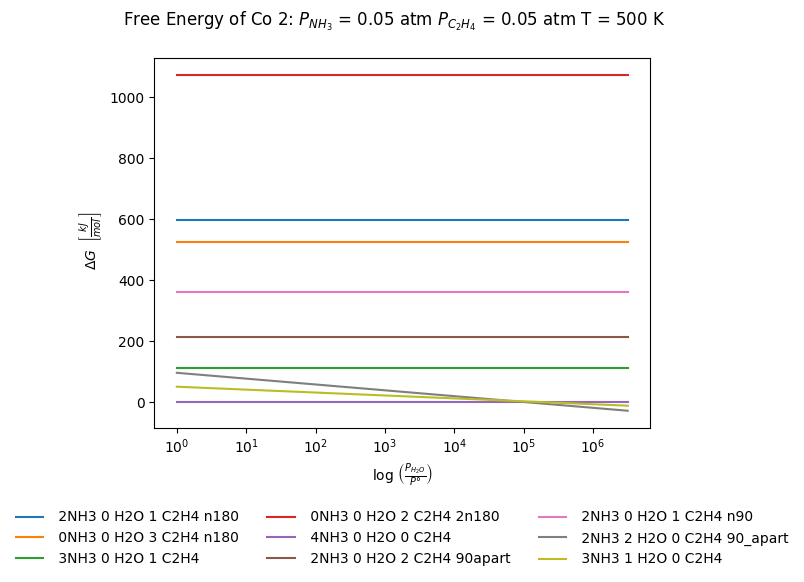

In [10]:
# VARY P_H2O
pres_step = 0.1

p = np.arange(0, 6.5+pres_step, pres_step)

pressure_h2o = np.power(10, p) # units atm

cu2 = fourfold(data = new, temperature = interp_temp, p_nh3 = 0.05, p_h2o = pressure_h2o, p_c2h4 = 0.05)

vary_p_h2o = '/Users/mohan/Desktop/vary_p_h2o.png'

cu2.plot_vary_ph2o(vary_p_h2o)

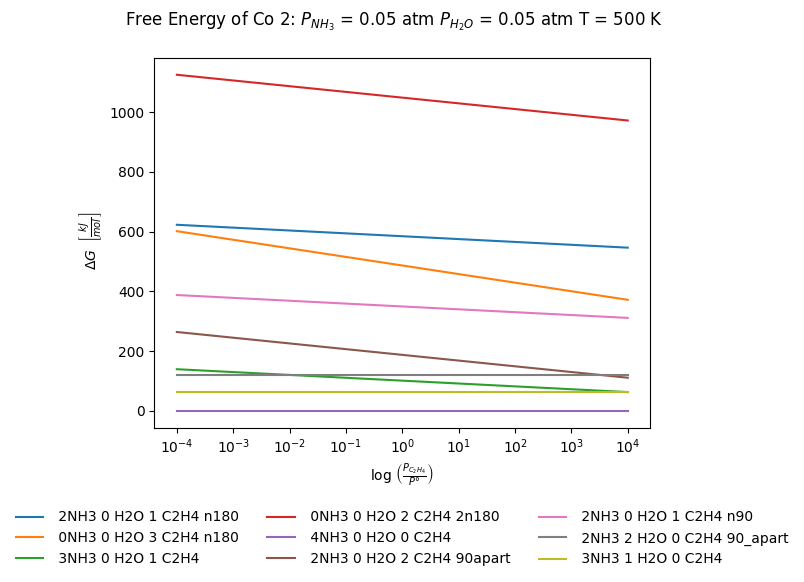

In [11]:
# VARY P_C2H4
pres_step = 0.1

p = np.arange(-4, 4+pres_step, pres_step)

pressure_c2h4 = np.power(10, p) # units atm

cu2 = fourfold(data = new, temperature = interp_temp, p_nh3 = 0.05, p_h2o = 0.05, p_c2h4 = pressure_c2h4)

vary_p_c2h4 = '/Users/mohan/Desktop/vary_p_c2h4.png'

cu2.plot_vary_pc2h4(vary_p_c2h4)

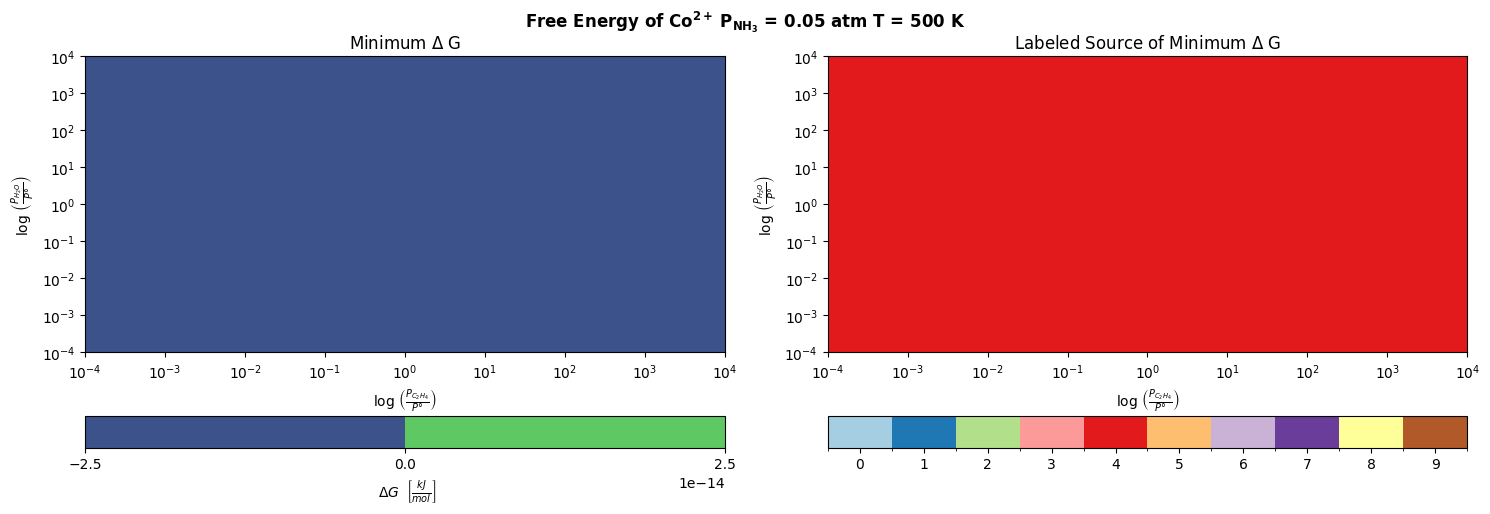

In [12]:
# VARY P_C2H4, P_H2O

pres_step = 0.01

p = np.arange(-4, 4+pres_step, pres_step)

pressure_h2o = np.power(10, p) # units atm

p = np.arange(-4, 4+pres_step, pres_step)

pressure_c2h4 = np.power(10, p) # units atm

cu2 = fourfold(data = new, temperature = interp_temp, p_nh3 = 0.05, p_h2o = pressure_h2o, p_c2h4 = pressure_c2h4)

vary_p_c2h4_h2o = '/Users/mohan/Desktop/vary_p_c2h4_h2o.png'

cu2.plot_vary_p_h2o_pc2h4(vary_p_c2h4_h2o)

In [13]:
new

,Metal,Charge,Geometry,NH3,H2O,C2H4,Description,Total Energy (Hartree),ZPE (kJ/mol),File Path,Entropy (kJ/mol*K),Delta E (kJ/mol),Delta S (kJ/mol*K)
0,Co,2,Square planar,2,0,1,n180,-1573.317922,324.614402,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.427117211060437,657.277258,-0.053834
1,Co,2,Square planar,0,0,3,n180,-1617.351867,411.305970,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.4531714694137388,570.301877,-0.027780
2,Co,2,Square planar,3,0,1,,-1630.025578,444.461425,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.4634698923428381,91.029106,-0.017482
3,Co,2,Square planar,0,0,2,2n180,-1538.608262,246.952256,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.44450714091270593,1229.862187,-0.036445
4,Co,2,Square planar,4,0,0,,-1608.059840,408.674503,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.4809516645227569,0.000000,0.000000
5,Co,2,Square planar,2,0,2,90apart,-1651.981993,482.613405,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.523844110425584,206.535381,0.042892
6,Co,2,Square planar,2,0,1,n90,-1573.408878,333.261250,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.4198038220606594,418.472621,-0.061148
7,Co,2,Square planar,2,2,0,90_apart,-1647.718885,334.581975,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.4620598486373522,115.443688,-0.018892
8,Co,2,Square planar,3,1,0,,-1627.889959,370.750818,/Users/mohan/Desktop/Research/paolucci/data/fr...,0.4636800894827225,56.156285,-0.017272
